In [1]:
# Import necessary libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

# ML Libraries
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

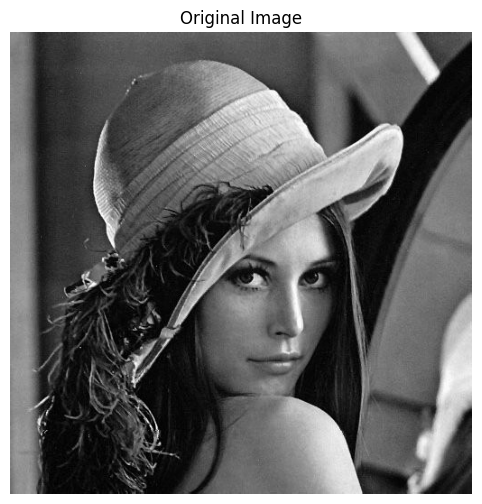

In [2]:
# Load an example image
image = cv2.imread('image.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
plt.figure(figsize=(10, 6))
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')
plt.show()

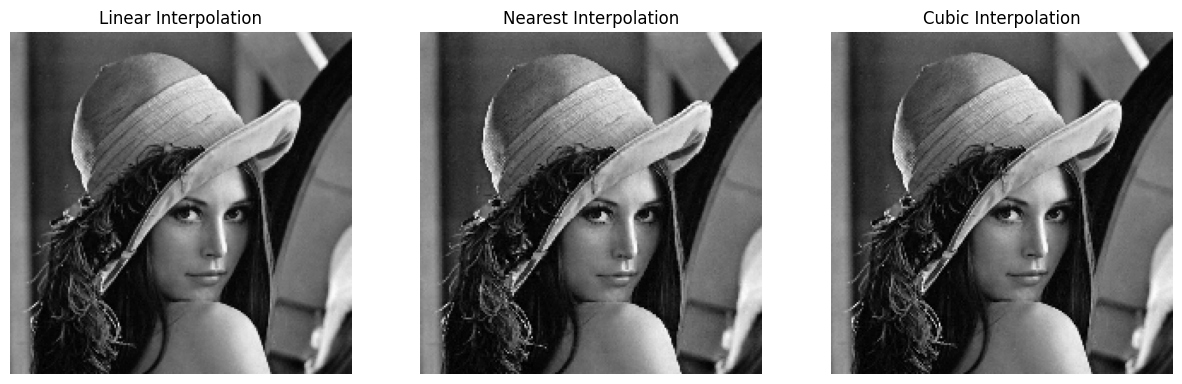

In [3]:
# 1.1 Image Resizing
def resize_image(image):
    resized_images = {}
    # 1.1.1 Linear Interpolation
    resized_images['Linear'] = cv2.resize(image, (200, 200), interpolation=cv2.INTER_LINEAR)
    # 1.1.2 Nearest Neighbors Interpolation
    resized_images['Nearest'] = cv2.resize(image, (200, 200), interpolation=cv2.INTER_NEAREST)
    # 1.1.3 Polynomial Interpolation
    resized_images['Cubic'] = cv2.resize(image, (200, 200), interpolation=cv2.INTER_CUBIC)
    return resized_images

resized_images = resize_image(image)

# Plot resized images
plt.figure(figsize=(15, 5))
for i, (title, img) in enumerate(resized_images.items()):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{title} Interpolation")
    plt.imshow(img)
    plt.axis('off')
plt.show()

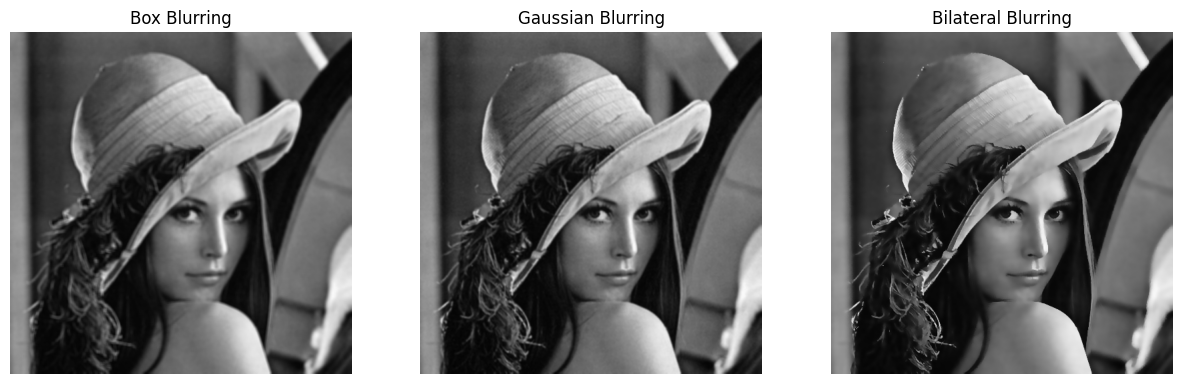

In [4]:
# 1.2 Image Blurring
def blur_image(image):
    blurred_images = {}
    # 1.2.1 Box Blurring
    blurred_images['Box'] = cv2.blur(image, (5, 5))
    # 1.2.2 Gaussian Blurring
    blurred_images['Gaussian'] = cv2.GaussianBlur(image, (5, 5), 0)
    # 1.2.3 Adaptive Blurring (Bilateral Filtering)
    blurred_images['Bilateral'] = cv2.bilateralFilter(image, 9, 75, 75)
    return blurred_images

blurred_images = blur_image(image)

# Plot blurred images
plt.figure(figsize=(15, 5))
for i, (title, img) in enumerate(blurred_images.items()):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{title} Blurring")
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [5]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target.astype('int')

# Split dataset (80-20 train-test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset loaded successfully.")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Use PCA to reduce dimensions
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Use a subset of the data
X_train_small, _, y_train_small, _ = train_test_split(X_train_pca, y_train, test_size=0.9, random_state=42)
X_test_small, _, y_test_small, _ = train_test_split(X_test_pca, y_test, test_size=0.9, random_state=42)


Dataset loaded successfully.
Training samples: 56000, Test samples: 14000


In [6]:
# Algorithms to use
models = {
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, kernel='linear', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'AdaBoost': AdaBoostClassifier(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300)
}

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test_small)
    y_prob = model.predict_proba(X_test_small)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    accuracy = accuracy_score(y_test_small, y_pred)
    precision = precision_score(y_test_small, y_pred, average='weighted')
    recall = recall_score(y_test_small, y_pred, average='weighted')
    f1 = f1_score(y_test_small, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test_small, y_pred)

    # ROC and AUC
    if y_prob is not None:
        # Ensure y_test_small is numeric for ROC curve computation
        y_test_binary = (y_test_small == np.unique(y_test_small)[0]).astype(int)  # Binary classification
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, roc_auc = None, None, None


    # Save results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Confusion Matrix': conf_matrix,
        'ROC Curve': (fpr, tpr),
        'AUC': roc_auc
    }

    # Print metrics
    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    if roc_auc:
        print(f"AUC: {roc_auc:.4f}\n")

Training Naive Bayes...
Results for Naive Bayes:
Accuracy: 0.8671
Precision: 0.8693
Recall: 0.8671
F1-Score: 0.8678
Confusion Matrix:
[[132   0   2   1   1   2   3   0   0   0]
 [  0 150   2   1   0   2   0   0   2   0]
 [  1   0 104   4   1   0   2   2   9   1]
 [  0   0   4 114   0   6   3   2   5   4]
 [  0   0   2   0 106   2   0   1   1  20]
 [  0   1   3   7   1  95   3   1   4   1]
 [  1   0   1   1   2   5 156   0   1   0]
 [  1   2   4   0   4   0   0 139   2   6]
 [  1   1   5   8   1   7   1   1 112   3]
 [  1   1   2   2  10   0   0   3   2 106]]
AUC: 0.1026

Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Results for SVM:
Accuracy: 0.7950
Precision: 0.7960
Recall: 0.7950
F1-Score: 0.7934
Confusion Matrix:
[[137   1   1   0   0   1   0   1   0   0]
 [  0 146   2   0   0   0   0   1   8   0]
 [  0   2 105   1   2   2   4   3   5   0]
 [  1   3   5 113   0   7   1   2   3   3]
 [  0   0   0   0 107   0   0   4   1  20]
 [  2   3   4  23   1  72   3   0   8   0]
 [  1   2   7   0   6   4 146   0   1   0]
 [  2   0   3   1   3   0   0 123   1  25]
 [  3   4   5  21   4  16   2   3  80   2]
 [  1   0   1   3  22   0   0  12   4  84]]
AUC: 0.1578

Training Random Forest...
Results for Random Forest:
Accuracy: 0.9079
Precision: 0.9088
Recall: 0.9079
F1-Score: 0.9075
Confusion Matrix:
[[133   0   1   2   1   0   2   2   0   0]
 [  0 153   2   1   0   1   0   0   0   0]
 [  0   2 108   2   2   0   2   3   4   1]
 [  0   1   2 124   0   1   2   4   2   2]
 [  1   0   1   0 118   0   0   0   1  11]
 [  0   1   3   3   0 103   3   1   2   0]
 [  2   0   0   1   2   0 162   0   0   0]
 [  0   1   2  

In [7]:
# Simplify model configurations
models = {
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, kernel='linear', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64,), max_iter=100, early_stopping=True)
}

# Train models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test_small)
    y_prob = model.predict_proba(X_test_small)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    accuracy = accuracy_score(y_test_small, y_pred)
    precision = precision_score(y_test_small, y_pred, average='weighted')
    recall = recall_score(y_test_small, y_pred, average='weighted')
    f1 = f1_score(y_test_small, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test_small, y_pred)

    print(f"Results for {name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")


Training Naive Bayes...
Results for Naive Bayes: Accuracy = 0.8671, Precision = 0.8693, Recall = 0.8671, F1 = 0.8678
Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Results for SVM: Accuracy = 0.7950, Precision = 0.7960, Recall = 0.7950, F1 = 0.7934
Training Random Forest...
Results for Random Forest: Accuracy = 0.8929, Precision = 0.8942, Recall = 0.8929, F1 = 0.8929
Training AdaBoost...
Results for AdaBoost: Accuracy = 0.5936, Precision = 0.6297, Recall = 0.5936, F1 = 0.6017
Training Neural Network...
Results for Neural Network: Accuracy = 0.8700, Precision = 0.8706, Recall = 0.8700, F1 = 0.8701


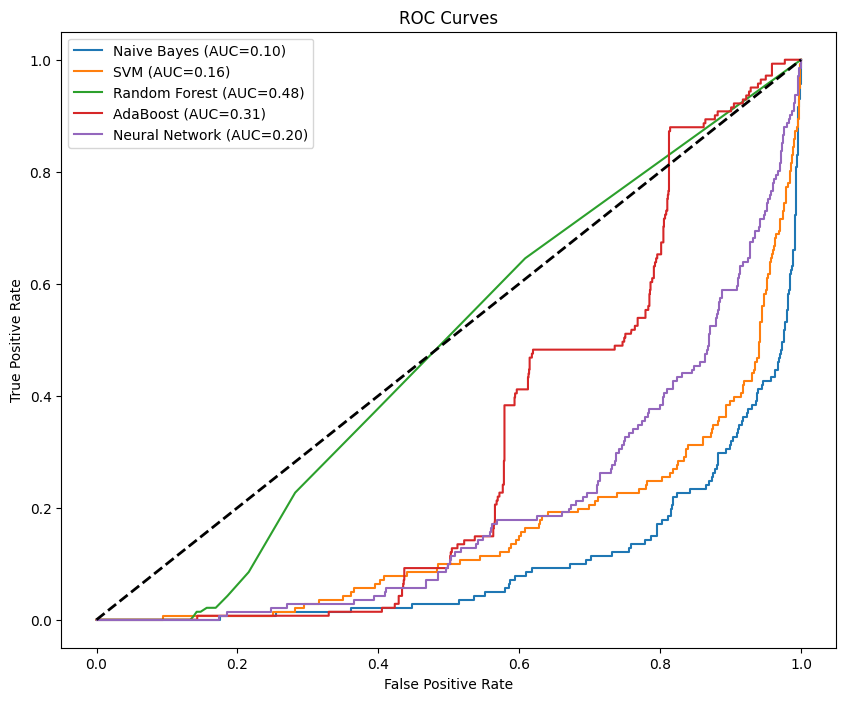

In [8]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for name, metrics in results.items():
    if metrics['ROC Curve'][0] is not None:
        plt.plot(metrics['ROC Curve'][0], metrics['ROC Curve'][1], label=f"{name} (AUC={metrics['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()